100%|██████████| 12/12 [00:00<00:00, 800.69it/s]


Text(0.5, 1.0, 'k-mer with k = 4 in up_genes')

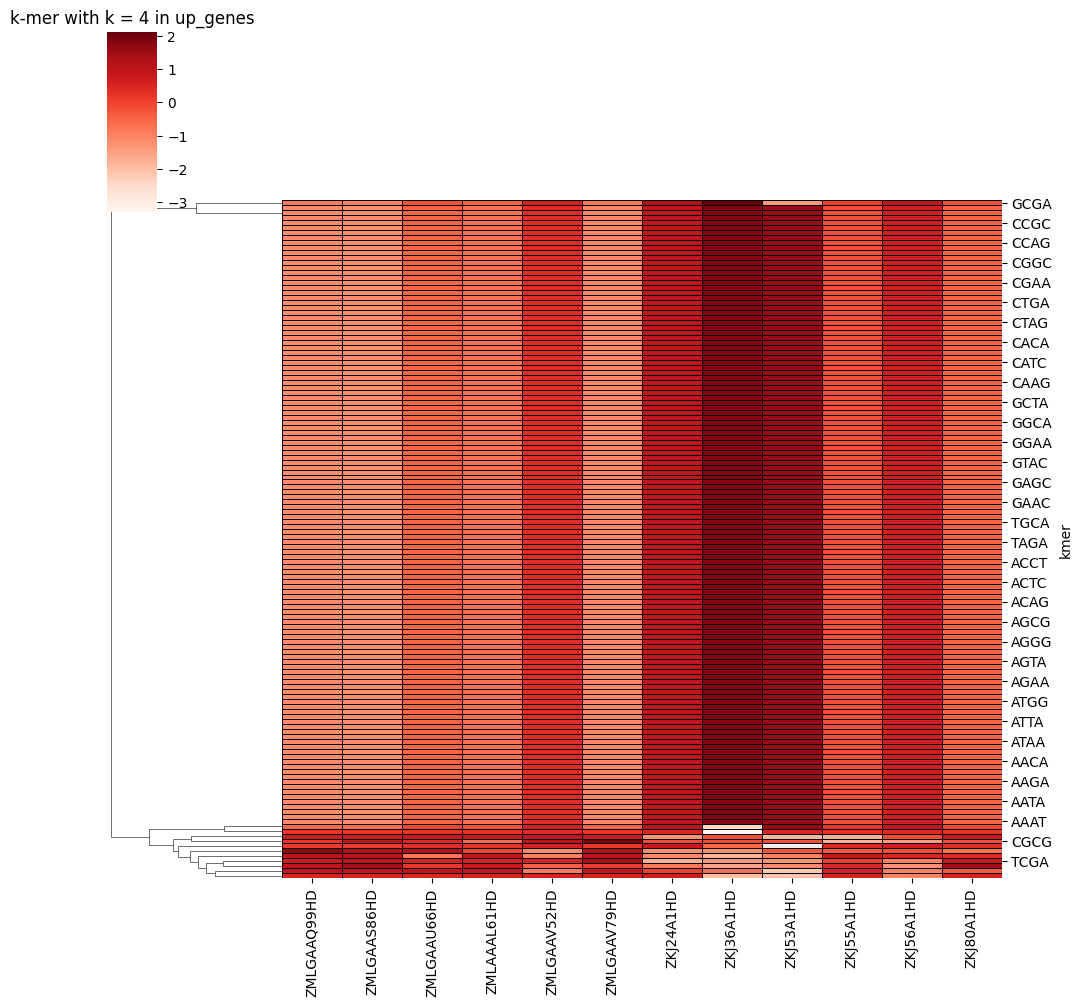

In [1]:
import pandas as pd
import numpy as np 
import pathlib 
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from itertools import product
import matplotlib.pyplot as plt

enrichment_type = "up_genes"
# enrichment_type = "down_genes"
# enrichment_type = "all_genes"
inputdir = f"/Volumes/HNSD01/outdir/highdepth_WGS_TSS_customGenes/kmc3_dump_count/Lung/biomart/{enrichment_type}"
kmer_size = 4

all_files = [item for item in pathlib.Path(inputdir).glob(f"*_{kmer_size}.txt")]

if kmer_size == 2:
    all_kmers = [f"{i}{j}" for i in "ACGT" for j in "ACGT"]
elif kmer_size == 3:
    all_kmers = [f"{i}{j}{k}" for i in "ACGT" for j in "ACGT" for k in "ACGT"]
else:
    all_kmers = [''.join(p) for p in product('ATGC', repeat=kmer_size)]
df = pd.DataFrame(data = all_kmers, columns = ["kmer"])

metadata = pd.read_csv("metadata.csv")
cancer_samples = metadata[metadata["Label"] == "Cancer"]["LABCODE"].tolist()
control_samples = metadata[metadata["Label"] == "Control"]["LABCODE"].tolist()
for file in tqdm(all_files):
    tmpdf = pd.read_csv(file, sep = "\t", header = None, names = ["kmer", "count"])
    sample = file.name.split("_")[0].split("-")[1]
    tmpdf["count"] = tmpdf["count"] / tmpdf["count"].sum()
    tmpdf.columns = ["kmer", sample]
    df = df.merge(tmpdf, on = "kmer", how = "left")
df.fillna(0, inplace = True)
df_origin = df.copy()

##### plot
scaler = StandardScaler()
df[df.columns[1:]] = scaler.fit_transform(df[df.columns[1:]].T).T
df = df.set_index("kmer")[cancer_samples + control_samples]
sns.clustermap(df[df.sum(axis=1) != 0], cmap="Reds", col_cluster=False, linewidths=0.5, linecolor='black')
plt.title(f"k-mer with k = {kmer_size} in {enrichment_type}")


W shape: (256, 2)
H shape: (2, 12)


/Users/hieunguyen/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


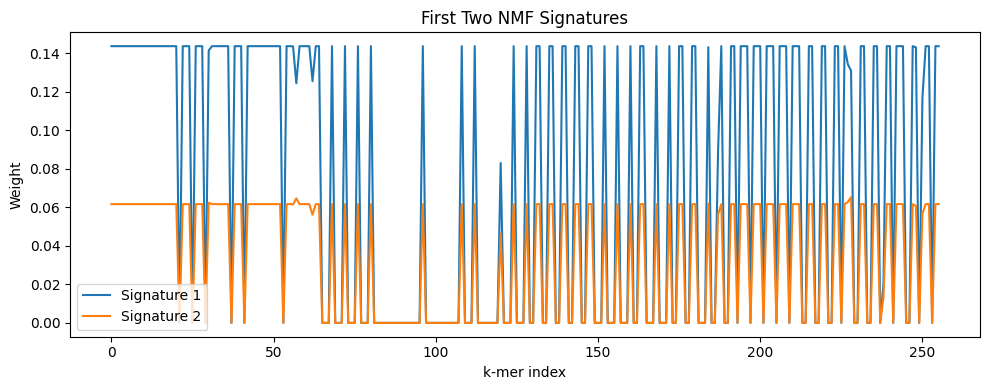

In [3]:
from sklearn.decomposition import NMF

# Apply NMF decomposition
n_components = 2  # You can adjust this number as needed
nmf = NMF(n_components=n_components, init='random', random_state=42)
W = nmf.fit_transform(df_origin.set_index("kmer"))
H = nmf.components_

H_normalized = H.T / H.T.sum(axis=1, keepdims=True)

# W: kmer x component matrix
# H: component x sample matrix
print("W shape:", W.shape)
print("H shape:", H.shape)

plt.figure(figsize=(10, 4))
for i in range(2):
    plt.plot(W[:, i], label=f'Signature {i+1}')
plt.xlabel('k-mer index')
plt.ylabel('Weight')
plt.title('First Two NMF Signatures')
plt.legend()
plt.tight_layout()
plt.show()

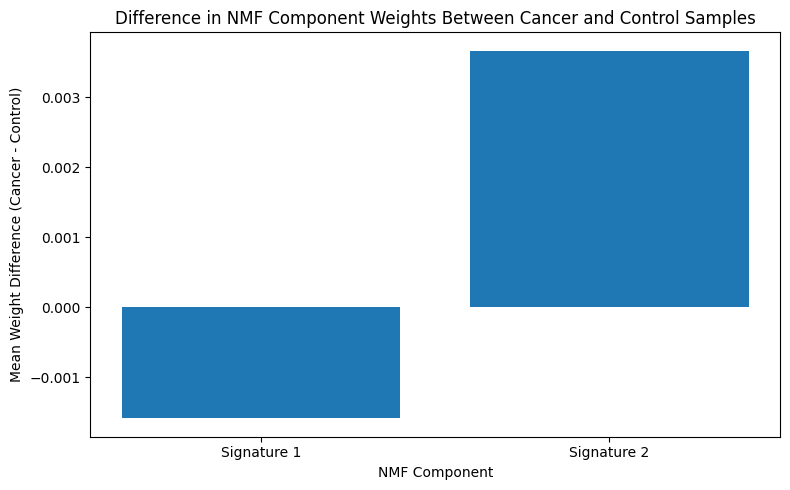

In [4]:
# Calculate mean weights for cancer and control samples for each component
cancer_indices = [df.columns.get_loc(s) for s in cancer_samples]
control_indices = [df.columns.get_loc(s) for s in control_samples]

# H shape: (n_components, n_samples)
cancer_means = H[:, cancer_indices].mean(axis=1)
control_means = H[:, control_indices].mean(axis=1)
diff = cancer_means - control_means

plt.figure(figsize=(8, 5))
plt.bar(range(n_components), diff)
plt.xlabel('NMF Component')
plt.ylabel('Mean Weight Difference (Cancer - Control)')
plt.title('Difference in NMF Component Weights Between Cancer and Control Samples')
plt.xticks(range(n_components), [f'Signature {i+1}' for i in range(n_components)])
plt.tight_layout()
plt.show()

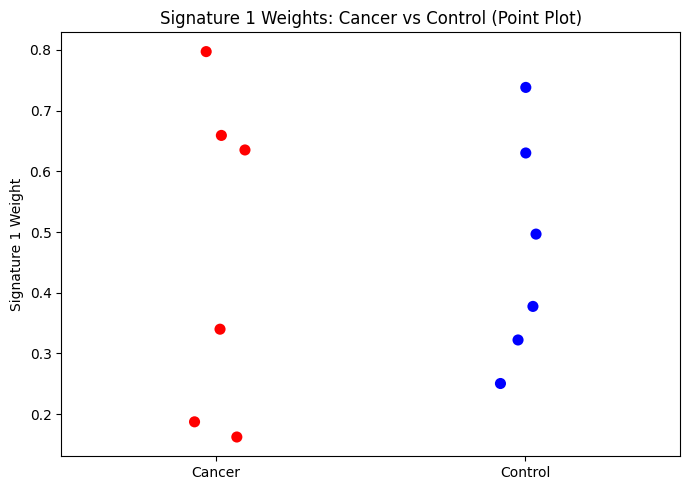

In [5]:
# Point plot for Signature 1 weights between cancer and control samples

signature_idx = 0  # Signature 1 is index 0
# signature_weights = H[signature_idx]
signature_weights = H_normalized[:, signature_idx]

plt.figure(figsize=(7, 5))
sns.stripplot(data=[signature_weights[cancer_indices], signature_weights[control_indices]],
              palette=["red", "blue"], size=8, jitter=True)
plt.xticks([0, 1], ["Cancer", "Control"])
plt.ylabel("Signature 1 Weight")
plt.title("Signature 1 Weights: Cancer vs Control (Point Plot)")
plt.tight_layout()
plt.show()

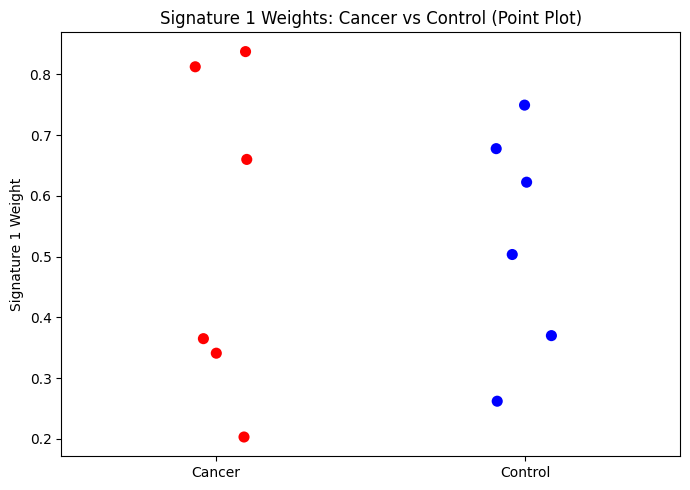

In [6]:
# Point plot for Signature 1 weights between cancer and control samples

signature_idx = 1  # Signature 1 is index 0
# signature_weights = H[signature_idx]
signature_weights = H_normalized[:, signature_idx]

plt.figure(figsize=(7, 5))
sns.stripplot(data=[signature_weights[cancer_indices], signature_weights[control_indices]],
              palette=["red", "blue"], size=8, jitter=True)
plt.xticks([0, 1], ["Cancer", "Control"])
plt.ylabel("Signature 1 Weight")
plt.title("Signature 1 Weights: Cancer vs Control (Point Plot)")
plt.tight_layout()
plt.show()